In [167]:
import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as skio
import cv2

In [21]:


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

imname = 'data/cathedral.jpg'
image = np.array(image)

image = torch.tensor(image, dtype=torch.float32).to(device) / 255.0

height = image.shape[0] // 3

b = image[:height].clone()
g = image[height:2*height].clone()
r = image[2*height:3*height].clone()

def l2_loss(a, b):
    return torch.sum((a - b) ** 2)

def ncc_loss(img1, img2):
    mean1 = torch.mean(img1)
    mean2 = torch.mean(img2)
    img1_centered = img1 - mean1
    img2_centered = img2 - mean2
    numerator = torch.sum(img1_centered * img2_centered)
    denominator = torch.sqrt(torch.sum(img1_centered ** 2) * torch.sum(img2_centered ** 2))
    ncc = numerator / (denominator + 1e-8)
    return -ncc

def align(img, reference, loss_fn, max_shift=15):
    best_shift = (0, 0)
    best_score = float('inf')

    for dx in range(-max_shift, max_shift + 1):
        for dy in range(-max_shift, max_shift + 1):
            shifted_img = torch.roll(torch.roll(img, dx, dims=0), dy, dims=1)
            
            score = loss_fn(shifted_img, reference)
            
            if score < best_score:
                best_score = score
                best_shift = (dx, dy)

    aligned_img = torch.roll(torch.roll(img, best_shift[0], dims=0), best_shift[1], dims=1)
    return aligned_img

In [116]:
print(image.shape)

torch.Size([1024, 390])


(341, 390, 3)


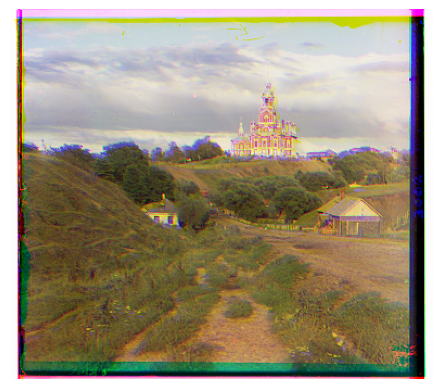

In [113]:
ag = align(g, b, l2_loss)
ar = align(r, b, l2_loss)

im_out = torch.stack([ar, ag, b], dim=-1).cpu().numpy()  
im_out = (im_out * 255).astype(np.uint8) 
print(im_out.shape)
im_out_img = Image.fromarray(im_out)
im_out_img.save('cathedral_l2.jpg')

plt.imshow(im_out_img)
plt.axis('off')
plt.show()

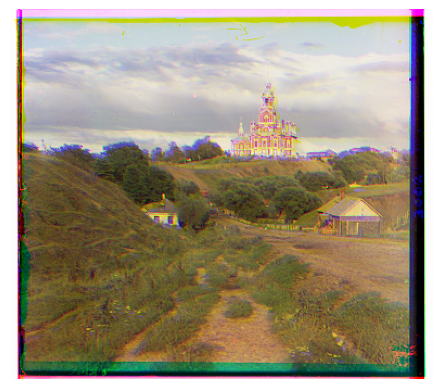

In [25]:
ag = align(g, b, ncc_loss)
ar = align(r, b, ncc_loss)

im_out = torch.stack([ar, ag, b], dim=-1).cpu().numpy()  

im_out = (im_out * 255).astype(np.uint8) 
im_out_img = Image.fromarray(im_out)
im_out_img.save('cathedral_ncc.jpg')

plt.imshow(im_out_img)
plt.axis('off')
plt.show()

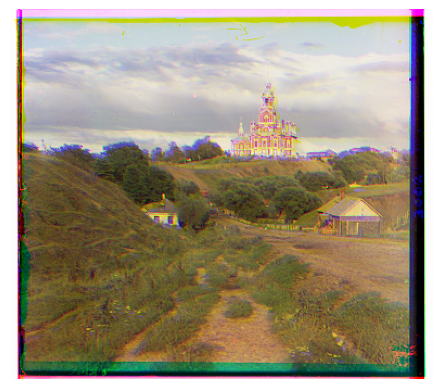

In [96]:
def center_normalize(img):
    mean = torch.mean(img)
    std = torch.std(img)
    img_normalized = (img - mean) / std
    
    return img_normalized

def crop_edge(img, crop_percentage = 0.1):
    height, width = img.shape[0], img.shape[1]  
    crop_h = int(height * crop_percentage)
    crop_w = int(width * crop_percentage)
    cropped_img = img[crop_h:height-crop_h, crop_w:width-crop_w]
    return cropped_img

def modified_align(img, norm_img, norm_ref, loss_fn, max_shift=15):
    best_shift = (0, 0)
    best_score = float('inf')

    for dx in range(-max_shift, max_shift + 1):
        for dy in range(-max_shift, max_shift + 1):
            shifted_img = torch.roll(torch.roll(norm_img, dx, dims=0), dy, dims=1)
            
            score = loss_fn(shifted_img, norm_ref)
            
            if score < best_score:
                best_score = score
                best_shift = (dx, dy)

    aligned_img = torch.roll(torch.roll(img, best_shift[0], dims=0), best_shift[1], dims=1)
    return aligned_img


new_g, new_b, new_r = crop_edge(center_normalize(g)), crop_edge(center_normalize(b)), crop_edge(center_normalize(r))
ag = modified_align(g, new_g, new_b, l2_loss)
ar = modified_align(r, new_r, new_b, l2_loss)

res = torch.stack([ar, ag, b], dim=-1).cpu().numpy()  

res = (res * 255).astype(np.uint8) 
res_img = Image.fromarray(res)
res_img.save('cathedral_modified_l2.jpg')

plt.imshow(im_out_img)
plt.axis('off')
plt.show()

Processing monastery.jpg


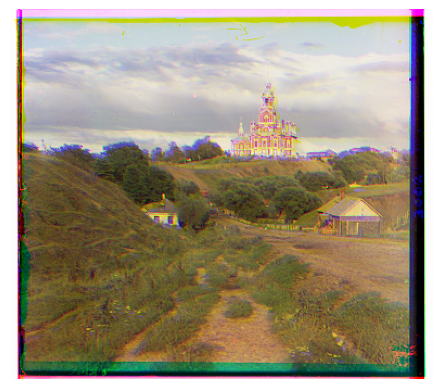

Finished processing monastery.jpg
Processing tobolsk.jpg


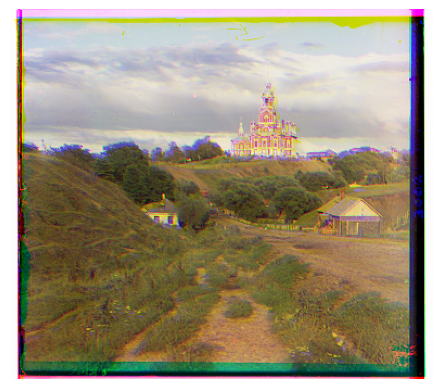

Finished processing tobolsk.jpg
Processing cathedral.jpg


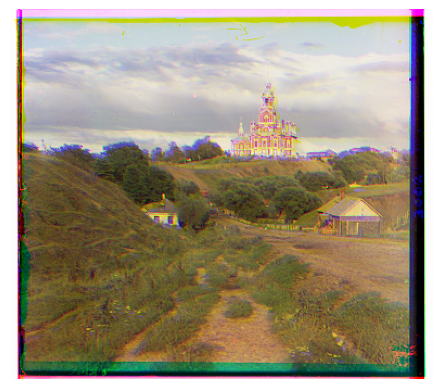

Finished processing cathedral.jpg


In [203]:
for image_file in os.listdir("data"):
    image_path = os.path.join("data", image_file)
    if os.path.isfile(image_path) and image_file.lower().endswith(('.jpg')):
        print(f"Processing {image_file}")
        output_dir = f"output/{image_file}"
        image = skio.imread(image_path)
        image = torch.tensor(image, dtype=torch.float32).to(device) / 255.0
        height = image.shape[0] // 3
        b = image[:height].clone()
        g = image[height:2*height].clone()
        r = image[2*height:3*height].clone()
        
        new_g, new_b, new_r = crop_edge(center_normalize(g)), crop_edge(center_normalize(b)), crop_edge(center_normalize(r))
        
        ag = modified_align(g, new_g, new_b, l2_loss)
        ar = modified_align(r, new_r, new_b, l2_loss)
        
        res = torch.stack([ar, ag, b], dim=-1).cpu().numpy()  
        
        res = (res * 255).astype(np.uint8) 
        res_img = Image.fromarray(res)
        res_img.save(output_dir)
        
        plt.imshow(res_img)
        plt.axis('off')
        plt.show()
        
        print(f"Finished processing {image_file}")

In [212]:
def downsample(img, scale_factor=2):
    img = img.unsqueeze(0).unsqueeze(0)
    img_downsampled = F.interpolate(img, size=(img.shape[2] // scale_factor, img.shape[3] // scale_factor), mode='bilinear', align_corners=False)
    img_downsampled = img_downsampled.squeeze(0).squeeze(0)
    return img_downsampled

def combine_and_save_image(r, g, b, output_path):
    res = torch.stack([r, g, b], dim=-1).cpu().numpy()
    im_out = (res * 255).astype(np.uint8)
    res = Image.fromarray(im_out)
    res.save(output_path)
    plt.imshow(res)
    plt.axis('off')
    plt.show()

def pyramid_and_modified_align(img, norm_img, norm_ref, loss_fn, min_size=50000, scale_factor=2, max_shift=15):
    
    shifts = (0, 0) 
    
    img_pyramid = []
    norm_img_pyramid = []
    norm_ref_pyramid = []

    # downsample
    while norm_img.shape[0] > min_size and norm_img.shape[1] > min_size:
        img_pyramid.append(img)
        norm_img_pyramid.append(norm_img)
        norm_ref_pyramid.append(norm_ref)
        img = downsample(img, scale_factor)
        norm_img = downsample(norm_img, scale_factor)
        norm_ref = downsample(norm_ref, scale_factor)

    aligned_norm_img = modified_align(img, norm_img, norm_ref, loss_fn, max_shift)

    # upscale
    while img_pyramid:
        img = img_pyramid.pop()
        norm_img = norm_img_pyramid.pop()
        norm_ref = norm_ref_pyramid.pop()
        
        shifts = (shifts[0] * scale_factor, shifts[1] * scale_factor)
        pre_aligned_img = torch.roll(torch.roll(norm_img, shifts[0], dims=0), shifts[1], dims=1)
        aligned_img, new_shifts = modified_align(pre_aligned_img, norm_img, norm_ref, loss_fn, max_shift=5)
        shifts = (shifts[0] + new_shifts[0], shifts[1] + new_shifts[1])
        
    aligned_img = torch.roll(torch.roll(img, shifts[0], dims=0), shifts[1], dims=1)
    
    return aligned_img


def calculate_shift(original, aligned):
    shift_y = torch.argmax(torch.sum(aligned, dim=1)) - torch.argmax(torch.sum(original, dim=1))
    shift_x = torch.argmax(torch.sum(aligned, dim=0)) - torch.argmax(torch.sum(original, dim=0))
    return (int(shift_y.item()), int(shift_x.item()))

def process(img_path, output_path):
    image = skio.imread(img_path)
    
    if image.dtype == np.uint16:
        image = torch.tensor(image, dtype=torch.float32).to(device) / 65535.0
    else:
        image = torch.tensor(image, dtype=torch.float32).to(device) / 255.0
        
    height = image.shape[0] // 3
    
    b = image[:height]
    g = image[height:2*height]
    r = image[2*height:3*height]

    crop_g, crop_b, crop_r = crop_edge(g), crop_edge(b), crop_edge(r)
    norm_g, norm_b, norm_r = center_normalize(crop_g), center_normalize(crop_b), center_normalize(crop_r)

    aligned_g = pyramid_and_modified_align(crop_g, norm_g, norm_b, ncc_loss)
    aligned_r = pyramid_and_modified_align(crop_r, norm_r, norm_b, ncc_loss)

    combine_and_save_image(aligned_r, aligned_g, crop_b, output_path)

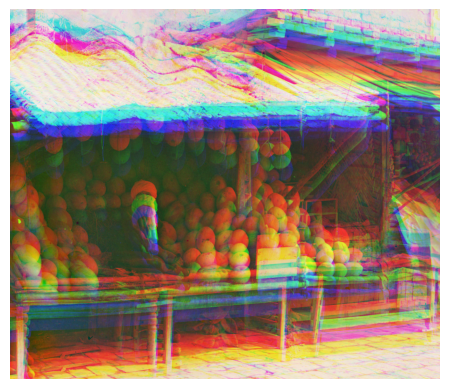

In [213]:
image_path = "data/melons.tif"
output_dir = f"output/output.jpg"
process(image_path, output_dir)

Processing emir.tif


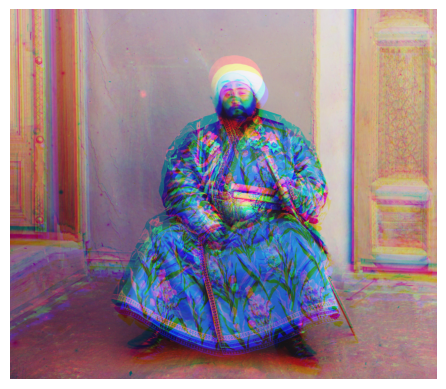

Finished processing emir.tif
Processing monastery.jpg


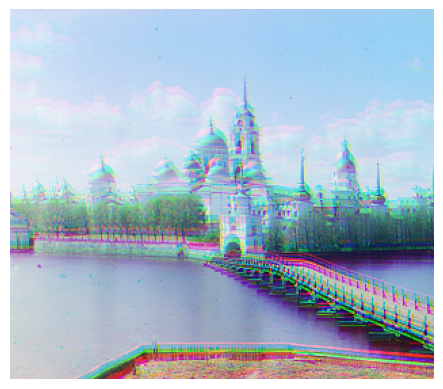

Finished processing monastery.jpg
Processing church.tif


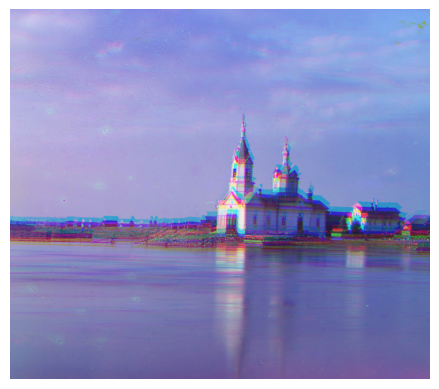

Finished processing church.tif
Processing three_generations.tif


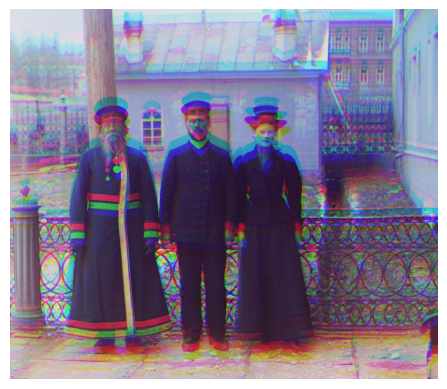

Finished processing three_generations.tif
Processing melons.tif


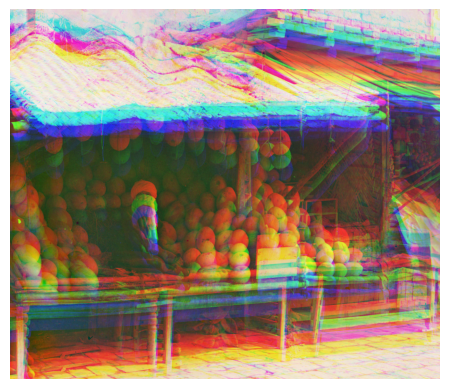

Finished processing melons.tif
Processing onion_church.tif


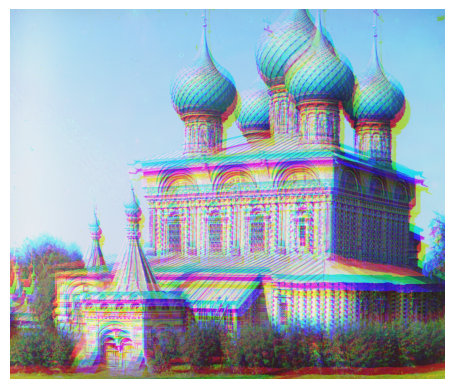

Finished processing onion_church.tif
Processing train.tif


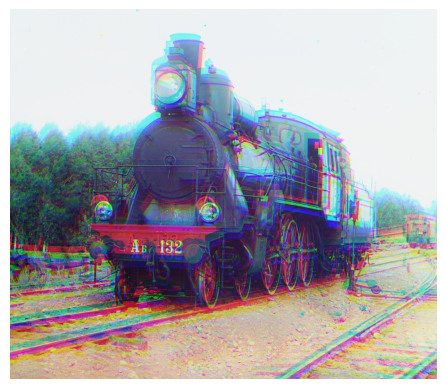

Finished processing train.tif
Processing tobolsk.jpg


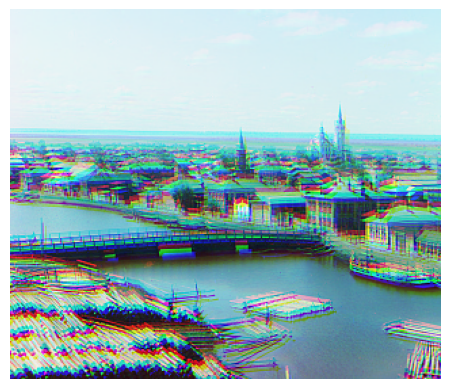

Finished processing tobolsk.jpg
Processing icon.tif


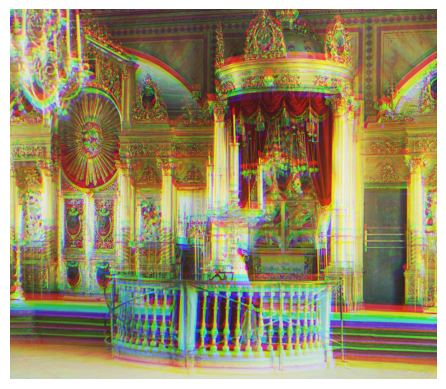

Finished processing icon.tif
Processing cathedral.jpg


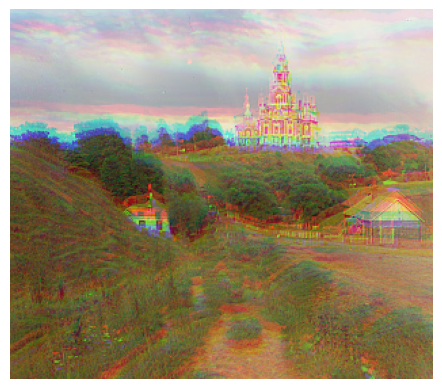

Finished processing cathedral.jpg
Processing self_portrait.tif


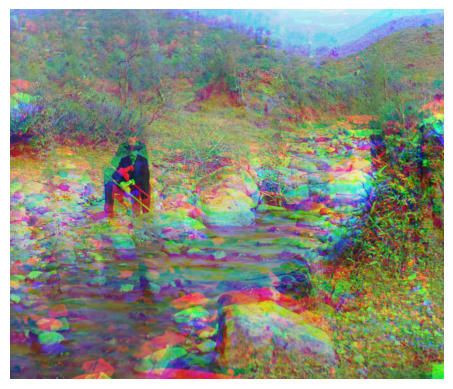

Finished processing self_portrait.tif
Processing harvesters.tif


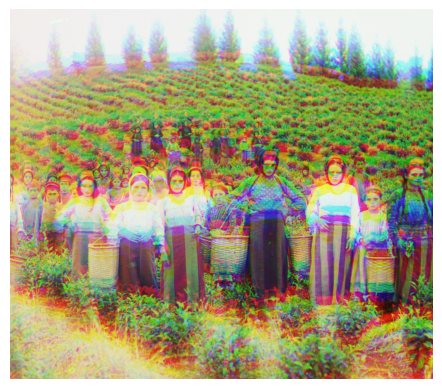

Finished processing harvesters.tif
Processing sculpture.tif


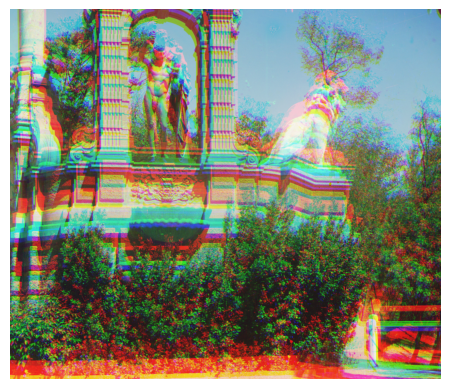

Finished processing sculpture.tif
Processing lady.tif


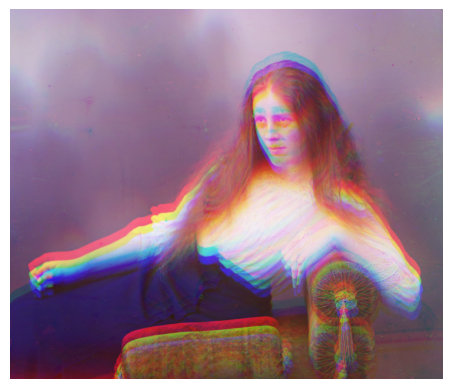

Finished processing lady.tif


In [214]:
import os
for image_file in os.listdir("data"):
    image_path = os.path.join("data", image_file)
    if os.path.isfile(image_path) and image_file.lower().endswith(('.jpg', "tif")):
        print(f"Processing {image_file}")
        output_dir = f"output/{image_file}"
        process(image_path, output_dir)
        print(f"Finished processing {image_file}")

In [215]:
# automatic edge detection with canny

def detect_borders(img, crop_percent=0.05):

    if img.dtype != np.uint8:
        print("converted to uint8")
        img = (img * 255).astype(np.uint8)
        
    if img.ndim == 3 and img.shape[-1] == 3:  # If RGB
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        img_gray = img
        
    edges = cv2.Canny(img, 100, 200)

    rows_with_edges = np.any(edges, axis=1)
    cols_with_edges = np.any(edges, axis=0)

    row_start = np.argmax(rows_with_edges)
    row_end = len(rows_with_edges) - np.argmax(np.flipud(rows_with_edges))
    col_start = np.argmax(cols_with_edges)
    col_end = len(cols_with_edges) - np.argmax(np.flipud(cols_with_edges))

    extra_row_crop = int((row_end - row_start) * crop_percent)
    extra_col_crop = int((col_end - col_start) * crop_percent)

    cropped_img = img[
        row_start + extra_row_crop: row_end - extra_row_crop,
        col_start + extra_col_crop: col_end - extra_col_crop
    ]
    
    return cropped_img

def process_with_automatic_edge_detection(img_path, output_path):
    image = skio.imread(img_path)
    
    if image.dtype == np.uint16:
        image = torch.tensor(image, dtype=torch.float32).to(device) / 65535.0
    else:
        image = torch.tensor(image, dtype=torch.float32).to(device) / 255.0
        
    height = image.shape[0] // 3
    
    b = image[:height]
    g = image[height:2*height]
    r = image[2*height:3*height]

    crop_g, crop_b, crop_r = detect_borders(g), detect_borders(b), detect_borders(r)
    norm_g, norm_b, norm_r = center_normalize(crop_g), center_normalize(crop_b), center_normalize(crop_r)

    aligned_g = pyramid_and_modified_align(g, new_g, new_b, l2_loss)
    aligned_r = pyramid_and_modified_align(r, new_r, new_b, l2_loss)

    combine_and_save_image(aligned_r, aligned_g, b, output_path)

In [216]:
image = skio.imread(image_path)
height = image.shape[0] // 3
    
b = image[:height]
g = image[height:2*height]
r = image[2*height:3*height]


 ag = modified_align(g, new_g, new_b, l2_loss)
ar = modified_align(r, new_r, new_b, l2_loss)


cropped = detect_borders(b)
res = Image.fromarray(cropped)
res = Image.fromarray(cropped)
res.show()

converted to uint8


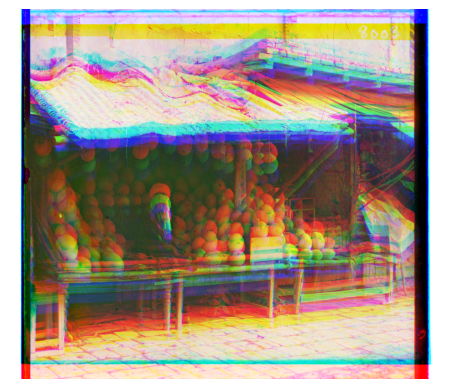

In [185]:
image_path = "data/melons.tif"
output_dir = f"output/output.jpg"
process(image_path, output_dir)

converted to uint8


AttributeError: 'numpy.ndarray' object has no attribute 'show'